In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve


In [47]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test.drop(["Clearsky DHI","Clearsky DNI","Clearsky GHI"],axis=1,inplace=True)
test_y = pd.read_csv("sample_submission.csv")

test = pd.concat([test,test_y],axis=1)

In [48]:
# Since time information is not important, we can drop it.
Time_columns = ["Year","Month","Hour","Minute"]

train.drop(Time_columns,axis=1,inplace=True)
test.drop(Time_columns,axis=1,inplace=True)

In [49]:
train_GHI = train["Clearsky GHI"].values
train.drop(["Clearsky GHI"],axis=1,inplace=True)

test_GHI = test["Clearsky GHI"].values

test.drop(["Clearsky GHI"],axis=1,inplace=True)

Scaler = MinMaxScaler()

train_GHI = Scaler.fit_transform(train_GHI.reshape(-1,1))
test_GHI = Scaler.fit_transform(test_GHI.reshape(-1,1))

train_GHI = train_GHI.ravel()
test_GHI = test_GHI.ravel()


In [50]:
Errors_rmse_GHI = []
all_columns = train.columns
Solar_zenith = ["Solar Zenith Angle"]
solar_temp = ["Solar Zenith Angle","Temperature"]

In [51]:
def Prepare_Train_Test(train,test,columns,Scaler):
    train_x = Scaler.fit_transform(train[columns].values)
    test_x = Scaler.fit_transform(test[columns].values)

    return train_x,test_x

# Setting 1: All columns

In [52]:
train_x,test_x = Prepare_Train_Test(train,test,all_columns,Scaler=MinMaxScaler())
RFR_GHI = RandomForestRegressor()
RFR_GHI.fit(train_x,train_GHI)
preds_GHI = RFR_GHI.predict(test_x)
rmse = mean_squared_error(preds_GHI,test_GHI) 
print(rmse)

Errors_rmse_GHI.append(rmse)

0.12718033216128236


# Setting 2 : Most Correlated Column

In [61]:
train_x,test_x = Prepare_Train_Test(train,test,Solar_zenith,Scaler=MinMaxScaler())

train_x = train_x.reshape(-1,1)
test_x = test_x.reshape(-1,1)
RFR_GHI = RandomForestRegressor()
RFR_GHI.fit(train_x,train_GHI)
preds_GHI = RFR_GHI.predict(test_x)

rmse = mean_squared_error(preds_GHI,test_GHI) 
print(rmse)

Errors_rmse_GHI.append(rmse)

0.1520200885169058


# Setting 3 : Most Correlated 2 Columns

In [62]:
train_x,test_x = Prepare_Train_Test(train,test,solar_temp,Scaler=MinMaxScaler())
RFR_GHI = RandomForestRegressor()
RFR_GHI.fit(train_x,train_GHI)
preds_GHI = RFR_GHI.predict(test_x)
rmse = mean_squared_error(preds_GHI,test_GHI) 
print(rmse)

Errors_rmse_GHI.append(rmse)

0.15150754309748599


# Setting 4 : Hyperparameter Tuned All Columns

In [56]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=2)
grid_search.fit(train_x, train_GHI)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [58]:
print("Best Parameters:", best_params)

# Make predictions using the best model
preds_GHI = best_model.predict(Prepare_Train_Test(train, test, all_columns, Scaler=MinMaxScaler())[1])

# Calculate and print RMSE
rmse = mean_squared_error(preds_GHI, test_GHI)
Errors_rmse_GHI.append(rmse)
print("RMSE:", rmse)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 0.12699283778623002


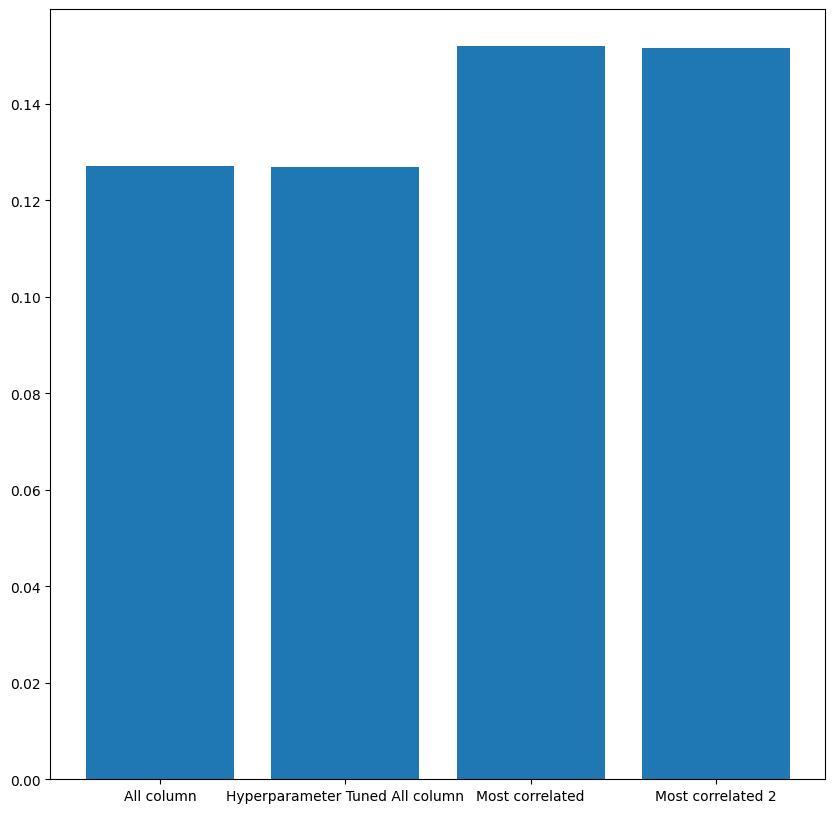

In [64]:
Settings = ["All column","Hyperparameter Tuned All column","Most correlated","Most correlated 2"]
fig = plt.figure(figsize=(10,10))
plt.bar(Settings,Errors_rmse_GHI)
plt.show()

Lowest RMSE score is obtained when all the columns had been used and hyperparameter tuning made so little difference(Computational time is an issue that's why no further experiments with parameter grid hadn't been done. More experiments may be done in the future)